In [1]:
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.debugger import set_trace

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
from pathlib import Path
import glob
import regex
import dill
import gzip
import toolz, itertools, more_itertools
from collections import Counter, OrderedDict

In [6]:
import optuna
import sklearn

In [7]:
import math
import pandas as pd 
import numpy as np
import seaborn as sns
from imblearn.combine import SMOTETomek
import statistics
import shap
np.random.seed(42)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## DATA directory
Note: Please change the DIR path accordingly  

In [8]:
DIR = Path(r'C:\Users\Abhij\OneDrive\Documents\GitHub\DNA-structure-prediction')
os.chdir(DIR)
assert DIR.exists()
DATA = DIR/"data"

## Helper Functions to read pickled data

In [9]:
def make_dirs(*, name: str) -> ():
    try:
        _file = DIR / "data"
        os.mkdir(_file / name)
    except FileExistsError:
        print("Dir exists")


def pkl_it(dataframe, filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "wb") as fh:
        dill.dump(dataframe, fh)
    return


def unpkl_it(filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "rb") as fh:
        return dill.load(fh)

make_dirs(name="results")
make_dirs(name="pkl")

Dir exists
Dir exists


## A flexible helper Class for running different ML algorithms  
It automatically chooses the best threshold for classification by locating the arg_max (index) of the best F-score  

In [10]:
import logging
from collections import defaultdict
logging.basicConfig(filename=DATA/'results.log', level=logging.INFO)
from utils.Evaluator import Call_Plot 


## Read curated dataset

In [11]:
curated_data = unpkl_it("curated_dataset")
curated_data

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6F3C,0,CGTACG,0,0,2,0,0,1,0,0,2,0,B
6GIM,0,AAATTT,4,0,0,0,1,0,0,0,0,0,B
6ASF,0,CCAAGATAG,1,1,0,1,1,1,2,1,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117D,1,GCGTACGTACGC,0,0,4,0,0,2,0,0,3,2,A
118D,1,GTGCGCAC,0,0,2,2,0,0,0,0,1,2,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A


In [12]:
#Check if any sequence has duplicate features
curated_data.drop_duplicates(subset=['AA/TT', 'GG/CC', 'AC/GT',
                                          'CA/TG', 'AT/AT', 'TA/TA', 'AG/CT', 'GA/TC', 'CG/CG', 'GC/GC'], keep='last')

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6F3C,0,CGTACG,0,0,2,0,0,1,0,0,2,0,B
6GIM,0,AAATTT,4,0,0,0,1,0,0,0,0,0,B
6ASF,0,CCAAGATAG,1,1,0,1,1,1,2,1,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117D,1,GCGTACGTACGC,0,0,4,0,0,2,0,0,3,2,A
118D,1,GTGCGCAC,0,0,2,2,0,0,0,0,1,2,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A


## Nested Cross-validation

In [13]:
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import RepeatedStratifiedKFold

from utils.NestedCV import gen_data, gen_data_for_tuningHP

The function gen_data is a flexible generator that implements outer fold of Nested CV  
Here, we are using 5-fold stratified Nested cross validation (n_splits = 5)  

This generator implements inner fold of Nested CV, where we tune hyperparameters.

## Read the best Naive Bayes hyperparameters

In [15]:
best_NB_params = pd.read_csv(DATA/"tuned_hyperparameters"/"best_NB_params.csv", index_col=0)

In [16]:
best_NB_params

,priors,var_smoothing
Model_1,NaN,1.400000e-06
Model_2,NaN,8.370000e-07
Model_3,NaN,1.290000e-04
Model_4,NaN,1.210000e-10
Model_5,NaN,1.790000e-09


## Set up Naive Bayes training

In [18]:
#Class weight factor:
SCALE_POS_WEIGHT = lambda T,P: (100*(T-P)/T) / (100*P/T)

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict
import optuna
from optuna.pruners import HyperbandPruner
import copy

In [26]:
def trainer(data, param_updater):
    #data, target = X_train, y_train
    train_x, train_y = data["X_train"], data["y_train"]
    
    param = {}
    param.update(param_updater)
    model = GaussianNB(**param)
    model.fit(train_x, train_y)
    return model



## Train, Run and evaluate performance of Naive Bayes using tuned hyperparameters

<IPython.core.display.Javascript object>


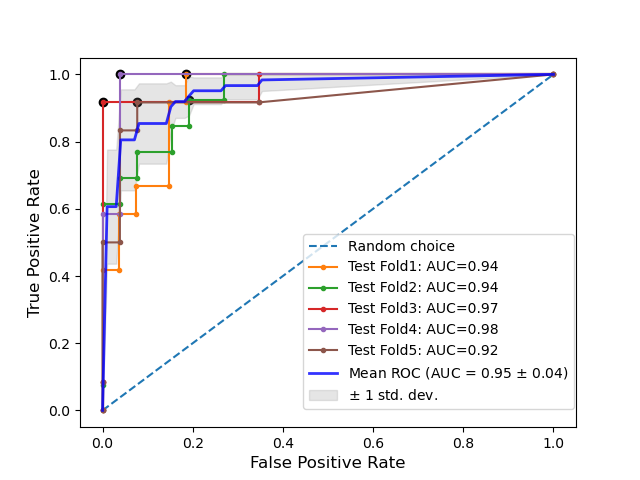

<IPython.core.display.Javascript object>


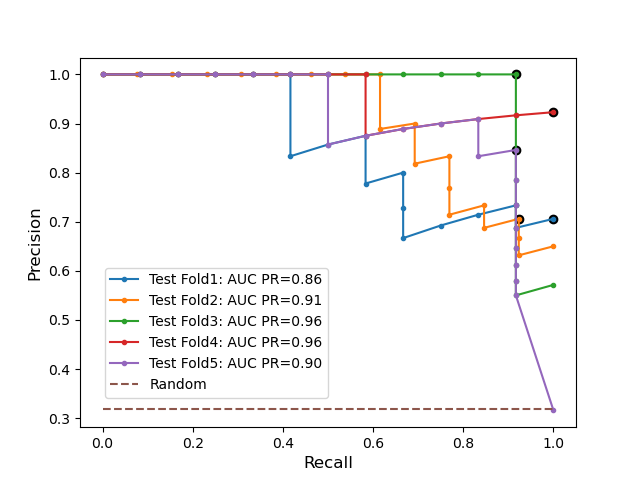

              precision    recall  f1-score   support

       B-DNA       0.96      0.81      0.88        27
       A-DNA       0.69      0.92      0.79        12

    accuracy                           0.85        39
   macro avg       0.82      0.87      0.83        39
weighted avg       0.87      0.85      0.85        39

Average PR:  0.8648293291675645
AUC PR:  0.8586235829802006
Best Threshold_f-score=0.092656, F-Score=0.828
AUC:  0.9351851851851852
Best Threshold_ROC=0.092656, G-Mean_ROC=0.903
Accuracy:  0.8461538461538461
F1:  0.7857142857142857
MCC:  0.6863599462712044
              precision    recall  f1-score   support

       B-DNA       0.91      0.81      0.86        26
       A-DNA       0.69      0.85      0.76        13

    accuracy                           0.82        39
   macro avg       0.80      0.83      0.81        39
weighted avg       0.84      0.82      0.82        39

Average PR:  0.9094268476621417
AUC PR:  0.9062686303204877
Best Threshold_f-score=0.7079

In [27]:
plt.close()
# *************OUTER*************
plot_Model_NB_test = Call_Plot(repeated_k_fold=False, model_name="NB", DIR=DIR)
for outer_idx, elem in enumerate(gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING=False)):
    # ***********INNER************
    model = trainer(elem, best_NB_params.dropna(how="any", axis=1).T.to_dict()
                    [f"Model_{outer_idx + 1}"])
    plot_Model_NB_test.Plot(elem, model, outer_idx)
plot_Model_NB_test.post_Plot()

In [24]:
pd.DataFrame(plot_Model_NB_test.results)

,Average PR,AUC PR,ROC AUC,Accuracy,F1,MCC,cohen_kappa_score
0,0.864829,0.858624,0.935185,0.846154,0.785714,0.686360,0.669492
1,0.909427,0.906269,0.943787,0.820513,0.758621,0.626628,0.618182
2,0.964286,0.963393,0.971154,0.947368,0.909091,0.879664,0.872483
3,0.961477,0.959474,0.983974,0.947368,0.916667,0.878205,0.878205
4,0.894577,0.901637,0.924679,0.894737,0.833333,0.756410,0.756410


In [25]:
pd.DataFrame(plot_Model_NB_test.results).mean()

Average PR           0.918919
AUC PR               0.917879
ROC AUC              0.951756
Accuracy             0.891228
F1                   0.840685
MCC                  0.765454
cohen_kappa_score    0.758954
dtype: float64

## Running from scratch - Run and evaluate performance of Naive Bayes under 5-fold stratified Nested CV

In [28]:

def objective(data, trial):
    train_x, valid_x, train_y, valid_y = data["X_train"], data["X_val"], data["y_train"], data["y_val"]


    param = {
        "var_smoothing": trial.suggest_loguniform("var_smoothing",1e-15,1e-2),        
    }
    
    model = GaussianNB(**param)
    model.fit(train_x, train_y)
    return sklearn.metrics.roc_auc_score(valid_y, model.predict(valid_x))

In [29]:
import collections
Trial = collections.namedtuple("Trial",["value", "parameters"])

<IPython.core.display.Javascript object>


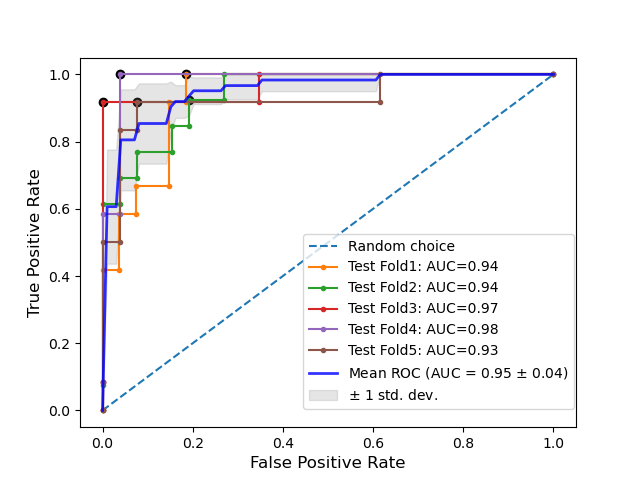

<IPython.core.display.Javascript object>


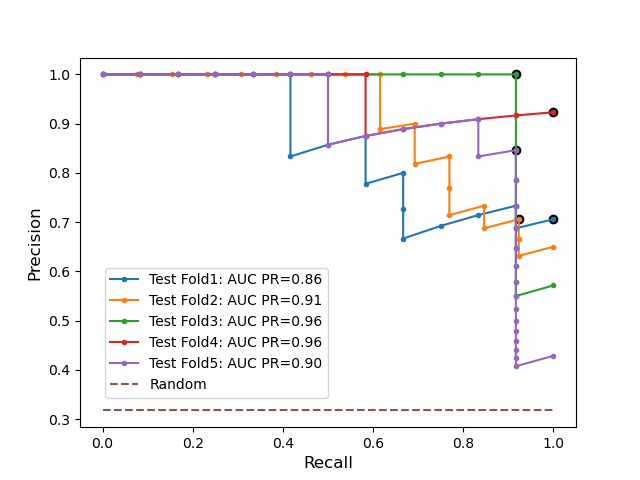

Number of finished trials: 100
Number of finished trials: 100
Number of finished trials: 100
              precision    recall  f1-score   support

       B-DNA       0.96      0.81      0.88        27
       A-DNA       0.69      0.92      0.79        12

    accuracy                           0.85        39
   macro avg       0.82      0.87      0.83        39
weighted avg       0.87      0.85      0.85        39

Average PR:  0.8648293291675645
AUC PR:  0.8586235829802006
Best Threshold_f-score=0.111881, F-Score=0.828
AUC:  0.9351851851851852
Best Threshold_ROC=0.111881, G-Mean_ROC=0.903
Accuracy:  0.8461538461538461
F1:  0.7857142857142857
MCC:  0.6863599462712044
Number of finished trials: 100
Number of finished trials: 100
Number of finished trials: 100
              precision    recall  f1-score   support

       B-DNA       0.91      0.81      0.86        26
       A-DNA       0.69      0.85      0.76        13

    accuracy                           0.82        39
   macro avg

In [31]:
plt.close()
optuna.logging.set_verbosity(optuna.logging.WARNING)
results = []
outer_models = {}
best_models_NB = {}

# *************OUTER*************
plot_Model_NB = Call_Plot(sklearn_model=True, model_name="Naive_Bayes")
for outer_idx, elem in enumerate(gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING = False)):

    study_dict_NB = {}
    # ***********INNER************
    for idx, data_in in enumerate(gen_data_for_tuningHP(elem, RESAMPLING=False)):
        
        study = optuna.create_study(pruner=HyperbandPruner(max_resource="auto"),
                            direction="maximize")
        study.optimize((toolz.curry(objective)(data_in)), n_trials=100)

        print("Number of finished trials: {}".format(len(study.trials)))

        trial = study.best_trial
        study_dict_NB[idx] = Trial(trial.value, trial.params)
    arg_max = max(study_dict_NB, key=lambda d: study_dict_NB[d].value) #max for AUC
    best_models_NB[outer_idx] = trainer(elem, study_dict_NB[arg_max].parameters)
    
    plot_Model_NB.Plot(elem, best_models_NB[outer_idx], outer_idx)
plot_Model_NB.post_Plot()


In [32]:
pd.DataFrame(plot_Model_NB_test.results)

,Average PR,AUC PR,ROC AUC,Accuracy,F1,MCC,cohen_kappa_score
0,0.864829,0.858624,0.935185,0.846154,0.785714,0.686360,0.669492
1,0.909427,0.906269,0.943787,0.820513,0.758621,0.626628,0.618182
2,0.964286,0.963393,0.971154,0.947368,0.909091,0.879664,0.872483
3,0.961477,0.959474,0.983974,0.947368,0.916667,0.878205,0.878205
4,0.894577,0.901637,0.924679,0.894737,0.833333,0.756410,0.756410


In [33]:
pd.DataFrame(plot_Model_NB_test.results).mean()

Average PR           0.918919
AUC PR               0.917879
ROC AUC              0.951756
Accuracy             0.891228
F1                   0.840685
MCC                  0.765454
cohen_kappa_score    0.758954
dtype: float64